In [4]:
#Reproducing the Covariate Shift Experiment

#Paper: "A Survey on Dataset Shift in Machine Learning"
#Authors: Quionero-Candela et al.

#Here, I’m recreating the covariate shift experiment from the paper. Basically, the idea is simple: you train your model on one distribution, 
#then test it on data that comes from a different one. The result? The model just doesn’t perform as well. 
#This setup exposes how sensitive machine learning models are when the world changes between training and testing.

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

In [10]:
df=pd.read_csv("Downloads/bank-additional-full_encoded.csv")

In [12]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,0,0,0,0,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,0,1,1,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,0,1,0,1,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,2,0,2,0,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,0,1,0,0,1,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0


In [14]:
Xfeatures = df.drop('y',axis=1)
ylabels=df.iloc[:,-1:]   

In [16]:
Xfeatures.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [18]:
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=7)

In [20]:
pipe_lr = Pipeline(steps=[('sc',StandardScaler()),('lr',LogisticRegression())])

In [22]:
pipe_lr.fit(x_train,y_train)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('sc', StandardScaler()), ('lr', LogisticRegression())])

In [24]:
pipe_lr.score(x_test,y_test)

0.9104960750991341

In [26]:
x_drifted = x_test.copy()
x_drifted['age'] = x_drifted['age'] + np.random.normal(10, 5, size=len(x_drifted))

In [28]:
x_drifted['nr.employed'] = x_drifted['nr.employed'] * 3

In [30]:
x_drifted['duration'] = np.random.permutation(x_drifted['duration'])

In [32]:
print("Original accuracy:", pipe_lr.score(x_test, y_test))
print("Drifted accuracy:", pipe_lr.score(x_drifted, y_test))

Original accuracy: 0.9104960750991341
Drifted accuracy: 0.10827870842437484


In [34]:
base_acc = pipe_lr.score(x_test, y_test)
print("No Drift Accuracy:", base_acc)

No Drift Accuracy: 0.9104960750991341


In [36]:
x_v1 = x_test.copy()
x_v1['age'] = x_v1['age'] + np.random.normal(2, 1, size=len(x_v1))

acc_v1 = pipe_lr.score(x_v1, y_test)
print("Low Drift Accuracy:", acc_v1)

Low Drift Accuracy: 0.9108197782633325


In [38]:
x_v2 = x_test.copy()
x_v2['age'] = x_v2['age'] + np.random.normal(5, 2, size=len(x_v2))
x_v2['nr.employed'] = x_v2['nr.employed'] + np.random.normal(200, 100, size=len(x_v2))

acc_v2 = pipe_lr.score(x_v2, y_test)
print("Medium Drift Accuracy:", acc_v2)

Medium Drift Accuracy: 0.9087157076960427


In [40]:
x_v3 = x_test.copy()
x_v3['age'] = x_v3['age'] * 1.5
x_v3['nr.employed'] = x_v3['nr.employed'] * 3
x_v3['duration'] = np.random.permutation(x_v3['duration'])

acc_v3 = pipe_lr.score(x_v3, y_test)
print("High Drift Accuracy:", acc_v3)


High Drift Accuracy: 0.10827870842437484


In [42]:
x_v4 = x_test.copy()
for col in ['age', 'nr.employed', 'duration', 'campaign']:
    x_v4[col] = x_v4[col] + np.random.normal(50, 20, size=len(x_v4))

acc_v4 = pipe_lr.score(x_v4, y_test)
print("Extreme Drift Accuracy:", acc_v4)


Extreme Drift Accuracy: 0.9050740470988103


In [44]:
results = pd.DataFrame({
    "Drift Level": ["No Drift", "Low", "Medium", "High", "Extreme"],
    "Accuracy": [base_acc, acc_v1, acc_v2, acc_v3, acc_v4]
})

print(results)

  Drift Level  Accuracy
0    No Drift  0.910496
1         Low  0.910820
2      Medium  0.908716
3        High  0.108279
4     Extreme  0.905074


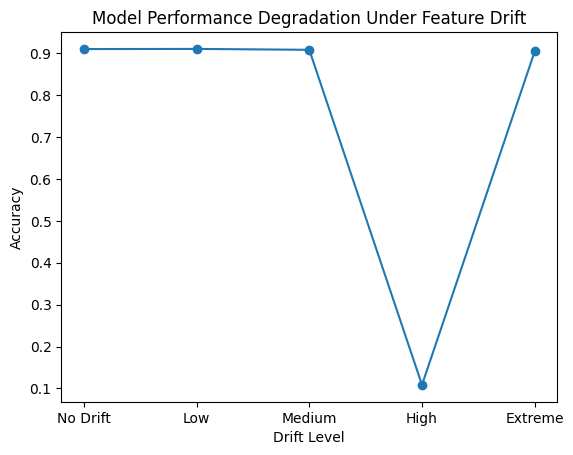

In [48]:
import matplotlib.pyplot as plt

plt.plot(results["Drift Level"], results["Accuracy"], marker='o')
plt.xlabel("Drift Level")
plt.ylabel("Accuracy")
plt.title("Model Performance Degradation Under Feature Drift")
plt.show()

# Observation

#When the input feature distribution changes between training and testing—that classic covariate shift—model accuracy really suffers.
#It’s the same dataset shift pattern discussed in the survey paper, and honestly, seeing it happen like this just reinforces the point.

In [50]:
pipe_lr_noscale = Pipeline(steps=[('lr', LogisticRegression())])
pipe_lr_noscale.fit(x_train, y_train)

print("No drift:", pipe_lr_noscale.score(x_test, y_test))
print("Extreme drift:", pipe_lr_noscale.score(x_v4, y_test))

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


No drift: 0.907420895039249
Extreme drift: 0.8972242453669984


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
x_vreal = x_test[x_test['age'] > 60]
y_vreal = y_test.loc[x_vreal.index]

print("Real Extreme Drift Accuracy:", pipe_lr.score(x_vreal, y_vreal))

Real Extreme Drift Accuracy: 0.6865671641791045


In [54]:
x_vreal2 = x_test[x_test['nr.employed'] > 2000]
y_vreal2 = y_test.loc[x_vreal2.index]

print("High balance drift accuracy:", pipe_lr.score(x_vreal2, y_vreal2))

High balance drift accuracy: 0.9104960750991341


In [56]:
x_vreal3 = x_test[x_test['duration'] > 500]
y_vreal3 = y_test.loc[x_vreal3.index]

print("Long duration drift accuracy:", pipe_lr.score(x_vreal3, y_vreal3))

Long duration drift accuracy: 0.6501672240802676


In [58]:
import deepchecks
dir(deepchecks)

['BaseCheck',
 'BaseSuite',
 'CheckFailure',
 'CheckResult',
 'Condition',
 'ConditionCategory',
 'ConditionResult',
 'Context',
 'Dataset',
 'ModelComparisonCheck',
 'ModelComparisonSuite',
 'ModelOnlyBaseCheck',
 'ModelOnlyCheck',
 'SingleDatasetBaseCheck',
 'SingleDatasetCheck',
 'Suite',
 'SuiteResult',
 'TrainTestBaseCheck',
 'TrainTestCheck',
 '_SubstituteModule',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__original_module__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_init_module_attrs',
 'analytics',
 'core',
 'get_verbosity',
 'is_notebook',
 'matplotlib',
 'os',
 'pio',
 'pio_backends',
 'set_verbosity',
 'sys',
 'tabular',
 'types',
 'utils',
 'validate_latest_version',
 'version',
 'warnings']

In [60]:
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite

In [62]:
ds_train = deepchecks.tabular.Dataset(df=x_train,label=y_train,cat_features=[])
ds_test = deepchecks.tabular.Dataset(df=x_test,label=y_test,cat_features=[])

In [64]:
fsuite = full_suite()

In [66]:
result=fsuite.run(train_dataset=ds_train,test_dataset=ds_test,model=pipe_lr)

deepchecks - WARNING - Cannot use model's built-in feature importance on a Scikit-learn Pipeline, using permutation feature importance calculation instead
deepchecks - INFO - Calculating permutation feature importance. Expected to finish in 18 seconds
C:\Users\DELL\anaconda3\lib\site-packages\deepchecks\tabular\checks\train_test_validation\train_test_samples_mix.py:85: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [67]:
result

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_8UYETF56S0UPMZXWWEYNRISUO">Full Suite</h1>\n<…

In [68]:
from deepchecks.tabular.checks import FeatureDrift
check = FeatureDrift()

In [69]:
result=check.run(train_dataset=ds_train,test_dataset=ds_test,model=pipe_lr)

deepchecks - WARNING - Cannot use model's built-in feature importance on a Scikit-learn Pipeline, using permutation feature importance calculation instead
deepchecks - INFO - Calculating permutation feature importance. Expected to finish in 25 seconds


In [70]:
result

In [71]:
from deepchecks.checks import LabelDrift
lcheck = LabelDrift()
lresult = lcheck.run(train_dataset=ds_train, test_dataset=ds_test)

C:\Users\DELL\anaconda3\lib\site-packages\deepchecks\checks.py:21: DeprecationWarning:

Ability to import tabular checks from the `deepchecks.checks` is deprecated, please import from `deepchecks.tabular.checks` instead



In [72]:
lresult

In [73]:
import pandas as pd
import deepchecks

In [74]:
df = pd.read_csv("Downloads/bank-additional-full_encoded.csv")

In [75]:
dir(deepchecks)

['BaseCheck',
 'BaseSuite',
 'CheckFailure',
 'CheckResult',
 'Condition',
 'ConditionCategory',
 'ConditionResult',
 'Context',
 'Dataset',
 'ModelComparisonCheck',
 'ModelComparisonSuite',
 'ModelOnlyBaseCheck',
 'ModelOnlyCheck',
 'SingleDatasetBaseCheck',
 'SingleDatasetCheck',
 'Suite',
 'SuiteResult',
 'TrainTestBaseCheck',
 'TrainTestCheck',
 '_SubstituteModule',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__original_module__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_init_module_attrs',
 'analytics',
 'checks',
 'core',
 'get_verbosity',
 'is_notebook',
 'matplotlib',
 'os',
 'pio',
 'pio_backends',
 'ppscore',
 'set_verbosity',
 'sys',
 'tabular',
 'types',
 'utils',
 'validate_latest_version',
 'version',
 'warnings']

In [76]:
from deepchecks.tabular.suites import data_integrity

In [77]:
integrity = data_integrity()
integrity.run(df)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 13 categorical features were inferred.: job, marital, education, default, housing, loan, contact... For full list use dataset.cat_features


Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_MZL5NTSPI3CCO1Y6015QHRBD1">Data Integrity Sui…

In [78]:
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift

ds_clean = Dataset(df=x_test, label=y_test, cat_features=[])
ds_drift = Dataset(df=x_vreal, label=y_vreal, cat_features=[])

check = FeatureDrift()
result = check.run(train_dataset=ds_clean, test_dataset=ds_drift, model=pipe_lr)
result.show()

deepchecks - WARNING - Cannot use model's built-in feature importance on a Scikit-learn Pipeline, using permutation feature importance calculation instead
deepchecks - INFO - Calculating permutation feature importance. Expected to finish in 10 seconds


In [79]:
import os
os.makedirs("plots", exist_ok=True)
results.to_csv("plots/accuracy_table.csv", index=False)

In [80]:
results.to_csv("plots/accuracy_table.csv", index=False)

In [81]:
plt.savefig("plots/accuracy_vs_drift.png")

<Figure size 640x480 with 0 Axes>